In [1]:
#HR diagram: M(336 -555) by M336 (color color plot)

steps:
1. combine the three fits files into one median combined image to get rid of cosmic rays
2. find sources in the image and make a catalog
3. do photometry to get the magnitude of the sources found in each image
4. compare catalogs, only use sources found in each image for the HR diagram because otherwise it would not work
5. make HR diagram
6. also bonus: return parameters for gaussian fitting of each source

**Notes:**
This is done a bit out of order, because I was trying out different ways to make the catalog and to make the plots. 

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import ccd_utils as cutils
from scipy.optimize import curve_fit

from glob import glob 
import scipy.ndimage as ndi

import pandas as pd

In [2]:
def convert_to_flux(filename):
    """
    Function that extracts the header data from a fits file and converts the units for each pixel from counts to flux
    Then it returns the flux data and header data from the file

    this function was made in class in hstworkbook3
    
    Inputs: .fits file
    Outputs: flux data, primary header, header

    """
    with fits.open(filename) as hdul:
        header = hdul[1].header
        primary = hdul[0].header
        data = hdul[1].data
        
        
        photflam = header['PHOTFLAM']
        exptime = primary['EXPTIME']

        if header['BUNIT'].strip() == 'COUNTS':
            flux_data = data.copy() * photflam / exptime
        elif data['BUNIT'].strip() == 'COUNTS/S':
            flux_data = data.copy() * photflam

        return flux_data, header, primary

In [3]:
def circular_aperture(data, center, radius):
    """
    Extract a circular cutout from the input data

    Parameters:
    -----------
    data : `np.ndarray`
        the input data
    center : list or tuple
        the center of the circle to extract, in y-x order
    radius : int or float
        the radius of the circle in pixels

    Returns:
    -----------
    cutout : `np.ndarray`
        a square cutout of the data
    mask : `np.ndarray`
        the circular mask used for the operation
    """

    box_size = int(np.ceil(2 * radius))
    cutout = cutils.square_aperture(data, center = center, box_size = box_size)

    ys, xs = np.indices(cutout.shape) #creates grid of the cutout area as indices

    xc = cutout.shape[1] // 2 #approximate integer x center of cutout
    yc = cutout.shape[0] // 2

    #handle bits for the mask:
    #get the pixel start position for the mask:
    y0 = yc - (box_size // 2)
    x0 = xc - (box_size // 2)

    #now get the index coords
    x_coords = xs + x0
    y_coords = ys + y0

    #get the distance from center to calc the mask
    distance = np.sqrt((x_coords - xc)**2 + (y_coords - yc)**2)

    #anything where distance > radius, will be False, True is for all values within circle radius 

    mask = distance <= radius

    return cutout, mask

In [4]:
def gauss_2d(coords, amp, x0, y0, sigma_x, sigma_y):
    y, x = coords

    gauss = amp * np.exp(
        -(((x- x0)**2) / (2*sigma_x**2) + ((y - y0)**2 / (2 * sigma_y**2))
         ))
    return gauss.ravel() #ravel flattens the array to a 1d array

def fit_gauss2d(data, p0 = None):

    if p0 is None: 
        a0 = data.max()
        x0 = data.shape[1] / 2
        y0 = data.shape[0] / 2
        sigx0 = 0.5
        sigy0 = 0.5
        p0 = [a0, x0, y0, sigx0, sigy0]

    y, x = np.indices(data.shape)

    popt, pcov = curve_fit(gauss_2d, (y, x), data.ravel(), p0 = p0)

    return popt, pcov

In [5]:
def flux_to_apparent_mag(f, zp):
    """Function to convert flux values to apparent magnitude"""
    mag_data = -2.5 * np.log10(f) + zp
    return mag_data

def m_to_M(data, distance):
    """
    Function to convert apparant magnitude to absolute magnitude
    Inputs: Star aparant magnitude, star distance (float)
    Outputs: absolute magnitude (float)
    """
    abs_mag_data = data - (2.5 * np.log10((distance / 10)**2))
    return abs_mag_data

In [6]:
def median_combine(im1, im2, im3):
    """
    Function to median combine 3 2D arrays, used for cosmic ray removal
    Inputs: 3 2D arrays
    Output: 1 array
    """
    stack = np.array([im1, im2, im3]) #create 3D stack of dta arrays
    median_combined = np.median(stack, axis=0)
    return median_combined

In [7]:
def file_parser_and_combiner(filepath):
    """
    This function takes files in a given folder, converts the data to flux data, and reads the header and primary data to a dictionary.
    Then the files are median combined to remove cosmic rays

    Inputs: path to files (string)
    Outputs: 
        1. dictionary with file data, header, and primary for a given folder of files
        2. combined image (array)
    """
    filenames = glob(filepath + '*.fits')

    returns = {
        'flux_data' : [], 
        'header' : [], 
        'primary' : []
    }

    #grabbing flux data, header, and primary header information:
    for file in filenames: 
        f, h, p = convert_to_flux(file)
        returns['flux_data'].append(f)
        returns['header'].append(h)
        returns['primary'].append(p)

    #median combining the flux data of each file:
    fluxes = returns['flux_data'].copy()
    combined = median_combine(fluxes[0], fluxes[1], fluxes[2])
    
    return returns, combined

In [8]:
F336W_dict, combined_336 = file_parser_and_combiner("data-files/ccd_lab_1/F336W/")
F555W_dict, combined_555 = file_parser_and_combiner("data-files/ccd_lab_1/F555W/")

In [130]:
#F336W_dict['header']

In [9]:
def find_flux(flux_data, coord):
    """
    This function applies a circular aperture to find the totla flux in a set aperture around a given coordinate,
    and subtracts local background flux using an anulus around the aperture used. 

    Inputs: flux data (array), and coordinate of a source (list)
    Output: total background subtracted flux of the source at the given coordinate (float)
    """
    #flux within aperture:
    cutout, mask = circular_aperture(flux_data, center = coord, radius = 5)
    aperture_flux = cutout[mask].sum()
    
    #flux within anulus, set as a ring right outside the edge of the aperture:
    cutout_r2, mask_r2 = circular_aperture(flux_data, center = coord, radius = 7)
    cutout_r1, mask_r1 = circular_aperture(flux_data, center = coord, radius = 6)
    anulus_flux = cutout_r2[mask_r2].sum() - cutout_r1[mask_r1].sum()

    #returning background subtracted flux:
    return aperture_flux - anulus_flux

In [10]:
def flux_check(flux):
    """
    This function will check if an inputted flux is positive
    """
    if flux > 0:
        return True
    else: return False

In [11]:
def check_ellipticity(sigma_x, sigma_y, etol=0.5):
    """
    Use Gaussian parameters to calculate the flattening or ellipticity (credt: assignment guidelines)
    """
    f = 1 - (min(sigma_x, sigma_y) / max(sigma_x, sigma_y))

    ellipse_okay = f <= etol

    if ellipse_okay:
        return True 
    else: return False

In [81]:
def check_location(coords):
    """Function to check if the found peak is at the edge of the array, where there is noise that reads as stars"""
    if (coord[0] == 799) or (coord[0] == 0) or (coord[1] == 799) or (coord[1] == 0) :
        return False
    else: return True

In [12]:
def fwhm_2d(sigma_x, sigma_y):
    """A function for finding the FHWM of sources, so I can look for trends across the sources I detect"""
    fwhm_x = 2.3548 * sigma_x
    fwhm_y = 2.3548 * sigma_y
    return (fwhm_x + fwhm_y) / 2

In [65]:
def star_finder(data, nsize = 10):
    """
    Function to find local peaks, using total flux and elipticity of a 2d gaussian fit to decide if the peaks are star-like

    Inputs: data array, nsize (optional, set to 10)
    Outputs: 
        1. array of passed coordinates 
        2. array of failed coordinates (origionally foud but failed checks)
        3. list of FWHM at passed coordinates
    
    """

    smoothed_data = ndi.gaussian_filter(data, sigma=0.5, mode='reflect')
    local_max = ndi.maximum_filter(smoothed_data, size=nsize)
    local_max_mask = (local_max == smoothed_data)
    
    coordinates = np.argwhere(local_max_mask)

    #testing to see if each peak found fits star criteria:
    passed_coordinates = []
    failed_coordinates = []
    fwhm_list = []

    for coord in coordinates:
        flux = find_flux(data, coord)

        if flux > 0:
            try:
                cutout, mask = circular_aperture(data, center = coord.T, radius = 5)
                popt, pcov = fit_gauss2d(cutout)

                if check_ellipticity(popt[3], popt[4], etol=0.5):
                    passed_coordinates.append(coord)
                    fwhm_list.append(fwhm_2d(popt[3], popt[4]))
                    
                else: 
                    failed_coordinates.append(coord)
                    
            except:
                failed_coordinates.append(coord)
                continue
                
        else: failed_coordinates.append(coord)
    
    return np.array(passed_coordinates), np.array(failed_coordinates), fwhm_list

In [170]:
def peak_finder(data, nsize = 10):
    """
    Function to find local peaks, using total flux and elipticity of a 2d gaussian fit to decide if the peaks are star-like

    Inputs: data array, nsize (optional, set to 10)
    Outputs: array of coordinates of found peaks
    """

    smoothed_data = ndi.gaussian_filter(data, sigma=0.5, mode='reflect')
    local_max = ndi.maximum_filter(smoothed_data, size=nsize)
    local_max_mask = (local_max == smoothed_data)
    
    coordinates = np.argwhere(local_max_mask)
    return coordinates

In [98]:
def peak_checker(data, coordinates):
    """
    Function to check if found peaks are stars, allowing for a list of coordinates to be passed so that I could check the same 
    locations in both images

    Inputs: Flux data array, coordinates array
    Outputs: 
        1. array of passed coordinates 
        2. array of failed coordinates (origionally foud but failed checks)
        3. list of FWHM at passed coordinates

    """
    passed_coordinates = []
    failed_coordinates = []
    fwhm_list = []

    for coord in coordinates:
        flux = find_flux(data, coord)

        if flux > 0:
            try:
                cutout, mask = circular_aperture(data, center = coord.T, radius = 5)
                popt, pcov = fit_gauss2d(cutout)

                if check_ellipticity(popt[3], popt[4], etol=0.5):
                    passed_coordinates.append(coord)
                    fwhm_list.append(fwhm_2d(popt[3], popt[4]))
                    
                else: 
                    failed_coordinates.append(coord)
                    
            except:
                failed_coordinates.append(coord)
                continue
                
        else: failed_coordinates.append(coord)
    
    return np.array(passed_coordinates), np.array(failed_coordinates), fwhm_list

In [ ]:
def star_finder(data336, data555):
    """
    A function combining peak_finder and peak_checker so that peaks are found and checked (against star criteria) in 
    one image, then the coordinates passed are sent to the second image. Doing so makes it so that the stars found in both images have the
    same coordinates. This does leave out peaks that look good in one image but not in another. 

    Inputs: F336 Image Data, F555 Image Data (arrays)
    Ouputs: 
    1. lists of passed and failed coordinates for each filter
    2. list of FWHM os sources for each filter
    """

    coords_336 = peak_finder(data336)
    passed_336, failed_336, fwhm_336 = peak_checker(combined_336, coords_336)
    


In [169]:
coords_336 = peak_finder(combined_555)

In [143]:
passed_336, failed_336, fwhm_336 = peak_checker(combined_336, coords_336)

C:\Users\Bruce Ritter\AppData\Local\Temp\ipykernel_15044\1522888017.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gauss_2d, (y, x), data.ravel(), p0 = p0)


In [144]:
len(passed_336)

3218

In [145]:
coords_555 = peak_finder(combined_555)
passed_555, failed_555, fwhm_555 = peak_checker(combined_555, passed_336)

C:\Users\Bruce Ritter\AppData\Local\Temp\ipykernel_15044\1522888017.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gauss_2d, (y, x), data.ravel(), p0 = p0)


In [146]:
len(passed_555)

2658

In [186]:
coords_336 = peak_finder(combined_336)
passed_336, failed_336, fwhm_336 = peak_checker(combined_336, coords_336)

passed_555, failed_555, fwhm_555 = peak_checker(combined_555, passed_336)

C:\Users\Bruce Ritter\AppData\Local\Temp\ipykernel_15044\1522888017.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gauss_2d, (y, x), data.ravel(), p0 = p0)


In [187]:
len(passed_336)

3218

In [188]:
len(passed_555)

2658

In [189]:
for coord in passed_555: 
    if find_flux(combined_555, coord) < 0:
        print(f"negative flux found")

In [190]:
for coord in passed_555: 
    if find_flux(combined_336, coord) < 0:
        print(f"negative flux found")

In [124]:
#this works then? I do end up with less than what Andrew says is the low end of criteria tho

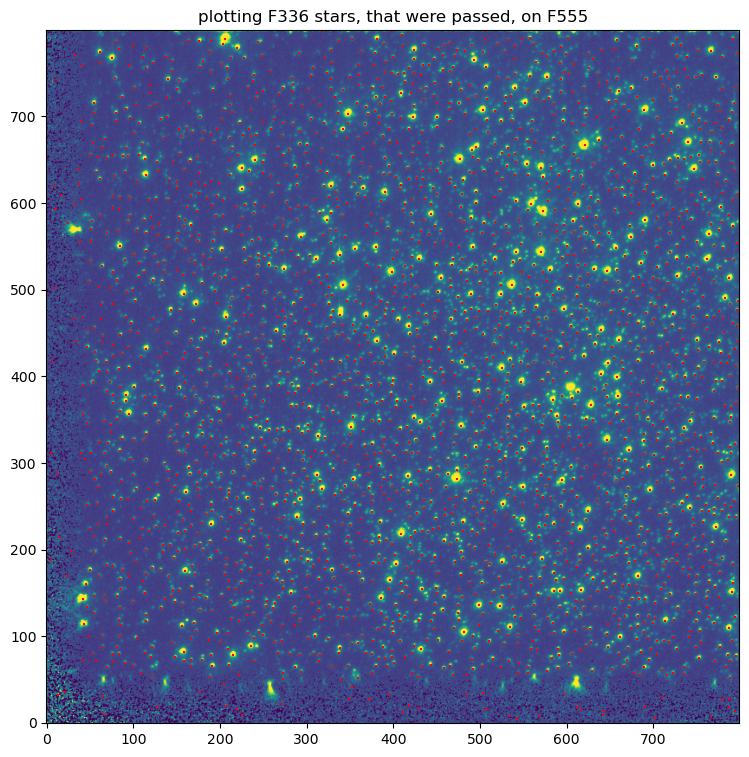

In [149]:
plt.close("all")
fig, ax= plt.subplots(figsize = (9, 9))
ax.set_title("plotting F336 stars, that were passed, on F555")
smoothed_555 = ndi.gaussian_filter(combined_555, sigma = 0.5, mode = 'reflect')
smooth_norm = cutils.transform_by('sqrt', smoothed_555, pmin = 1, pmax = 99)
ax.imshow(smooth_norm, origin = 'lower')

y, x = passed_555.T
ax.scatter(x, y, s = 4, marker = '+', color = 'r')
plt.show()

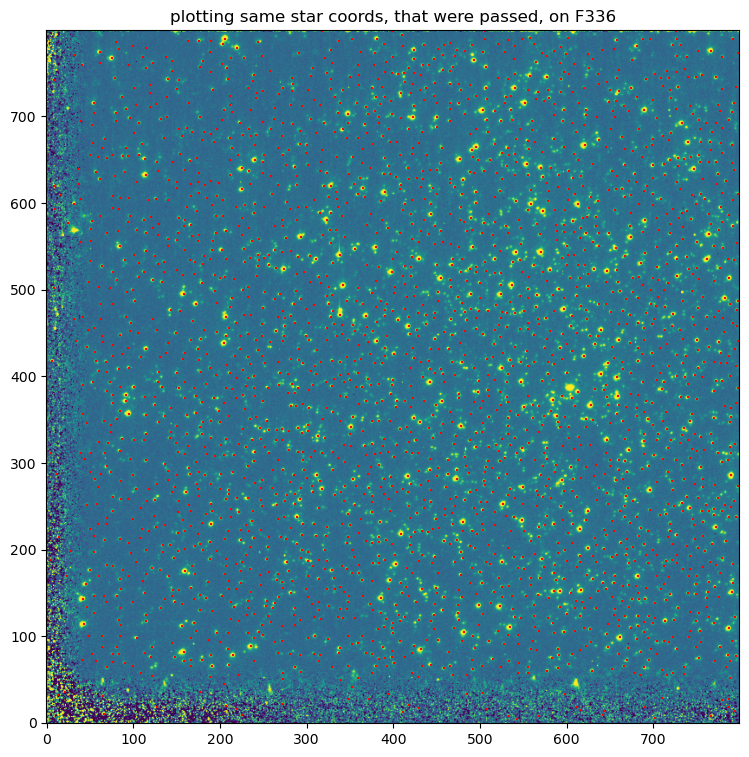

In [150]:
plt.close("all")
fig, ax= plt.subplots(figsize = (9, 9))
ax.set_title("plotting same star coords, that were passed, on F336")
smoothed_336 = ndi.gaussian_filter(combined_336, sigma = 0.5, mode = 'reflect')
smooth_norm = cutils.transform_by('sqrt', smoothed_336, pmin = 1, pmax = 99)
ax.imshow(smooth_norm, origin = 'lower')

y, x = passed_555.T
ax.scatter(x, y, s = 4, marker = '+', color = 'r')
plt.show()

In [168]:
def combo_catalog_creator(data336, data555, coords):
    """
    This function will create a catalog of found stars including their coordinates, 
    and for each filter: the star flux, aparent magnitude, and absolute magnitude

    Inputs: flux data array, array of passed (likely stars) coordinates
    Output: pandas dataframe:
        ID: ID of star
        x_center, y_center: center coordinates of star 
        F### flux: next flux within aperture, with background flux subtracted, for either filter
        F### Aparent Mag: apparent magnitude for either filter
        F### Absolute Mag: absolute magnitude for either filter
    """

     #creating a catalog: 

    fluxes336 = []
    for coord in coords:
        fluxes336.append(find_flux(data336, coord))\
        
    fluxes555 = []
    for coord in coords:
        fluxes555.append(find_flux(data555, coord))
    
    
    aparent_mags336 = []
    for flux in fluxes336:
        aparent_mags336.append(flux_to_apparent_mag(flux, -21.1)) #zp set to -21.1 for this data

    absolute_mags336 = []
    for mag in aparent_mags336:
        absolute_mags336.append(m_to_M(mag, 16400)) #distance = 16400 according to the hst workbook 3

    aparent_mags555 = []
    for flux in fluxes555:
        aparent_mags555.append(flux_to_apparent_mag(flux, -21.1)) #zp set to -21.1 for this data

    absolute_mags555 = []
    for mag in aparent_mags555:
        absolute_mags555.append(m_to_M(mag, 16400)) #distance = 16400 according to the hst workbook 3

    catalog_data = {
        'ID' : [i for i in range(len(coords))],
        'x center':  [coord[0] for coord in coords],
        'y center':  [coord[1] for coord in coords],
        'F336 Flux': fluxes336,
        'F555 Flux': fluxes555,
        'F336 Aparent Mag': aparent_mags336,
        'F555 Aparent Mag': aparent_mags555,
        'F336 Absolute Mag': absolute_mags336,
        'F555 Absolute Mag': absolute_mags555,
    }

    return pd.DataFrame(catalog_data)

In [192]:
catalog = combo_catalog_creator(combined_336, combined_555, passed_555)

In [193]:
catalog

ID  x center  y center     F336 Flux     F555 Flux  F336 Aparent Mag  \
0        0         5       543  3.548718e-18  7.032652e-18         22.524821   
1        1         6       702  9.546989e-17  8.509760e-18         18.950334   
2        2         8       534  2.645744e-17  1.885109e-18         20.343631   
3        3         8       568  5.887896e-18  4.984574e-18         21.975100   
4        4         8       767  4.985490e-17  3.332748e-18         19.655730   
...    ...       ...       ...           ...           ...               ...   
2653  2653       794       410  2.239116e-17  1.980223e-17         20.524808   
2654  2654       799       318  3.093126e-17  3.834314e-17         20.174006   
2655  2655       799       399  2.678331e-17  4.568680e-17         20.330339   
2656  2656       799       506  2.814770e-17  4.065369e-17         20.276393   
2657  2657       799       726  7.670030e-17  6.557915e-17         19.188007   

      F555 Aparent Mag  F336 Absolute Mag  F555 Absolute Mag  
0            21.782202           6.450602           5.707983  
1            21.575207           2.876115           5.500987  
2            23.211659           4.269411           7.137439  
3            22.155930           5.900881           6.081711  
4            22.592994           3.581511           6.518774  
...                ...                ...                ...  
2653         20.658215           4.450589           4.583996  
2654         19.940781           4.099787           3.866561  
2655         19.750523           4.256120           3.676304  
2656         19.877250           4.202174           3.803031  
2657         19.358086           3.113788           3.283866  

[2658 rows x 9 columns]

In [200]:
from IPython.display import display
display(catalog)

ID  x center  y center     F336 Flux     F555 Flux  F336 Aparent Mag  \
0        0         5       543  3.548718e-18  7.032652e-18         22.524821   
1        1         6       702  9.546989e-17  8.509760e-18         18.950334   
2        2         8       534  2.645744e-17  1.885109e-18         20.343631   
3        3         8       568  5.887896e-18  4.984574e-18         21.975100   
4        4         8       767  4.985490e-17  3.332748e-18         19.655730   
...    ...       ...       ...           ...           ...               ...   
2653  2653       794       410  2.239116e-17  1.980223e-17         20.524808   
2654  2654       799       318  3.093126e-17  3.834314e-17         20.174006   
2655  2655       799       399  2.678331e-17  4.568680e-17         20.330339   
2656  2656       799       506  2.814770e-17  4.065369e-17         20.276393   
2657  2657       799       726  7.670030e-17  6.557915e-17         19.188007   

      F555 Aparent Mag  F336 Absolute Mag  F555 Absolute Mag  
0            21.782202           6.450602           5.707983  
1            21.575207           2.876115           5.500987  
2            23.211659           4.269411           7.137439  
3            22.155930           5.900881           6.081711  
4            22.592994           3.581511           6.518774  
...                ...                ...                ...  
2653         20.658215           4.450589           4.583996  
2654         19.940781           4.099787           3.866561  
2655         19.750523           4.256120           3.676304  
2656         19.877250           4.202174           3.803031  
2657         19.358086           3.113788           3.283866  

[2658 rows x 9 columns]

In [199]:
catalog.to_csv('star_catalog.csv', index=False)

In [184]:
max(catalog['F336 Absolute Mag'])

9.794990442657642

In [185]:
max(catalog['F336 Aparent Mag'])

25.869209682896134

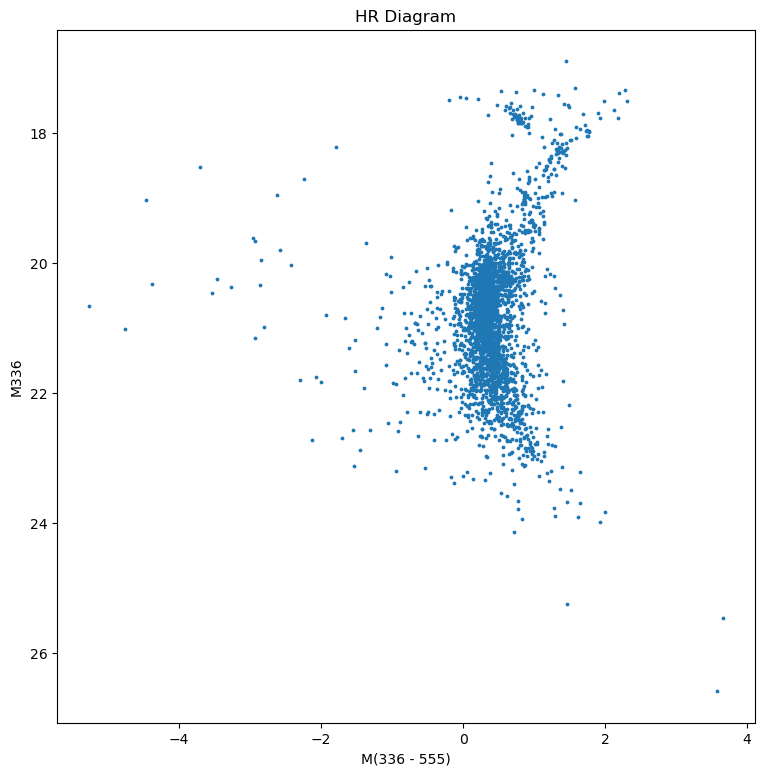

In [194]:
plt.close("all")
fig, ax = plt.subplots(figsize = (9,9))
ax.set_title("HR Diagram")
ax.set_ylabel("M336")
ax.set_xlabel("M(336 - 555)")

ax.scatter((catalog["F336 Aparent Mag"] - catalog["F555 Aparent Mag"]), catalog["F336 Aparent Mag"], s = 3)
plt.gca().invert_yaxis()
plt.show()

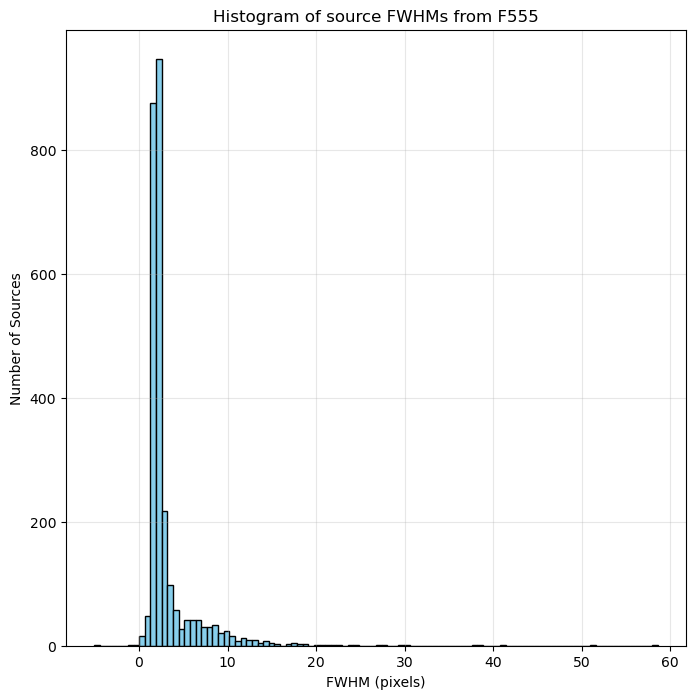

In [197]:
plt.close("all")
fig, ax = plt.subplots(figsize = (8, 8))
ax.set_title('Histogram of source FWHMs from F555')
ax.set_xlabel('FWHM (pixels)')
ax.set_ylabel('Number of Sources')

ax.hist(fwhm_555, bins=100, color='skyblue', edgecolor='black')

plt.grid(True, alpha=0.3)
plt.show()

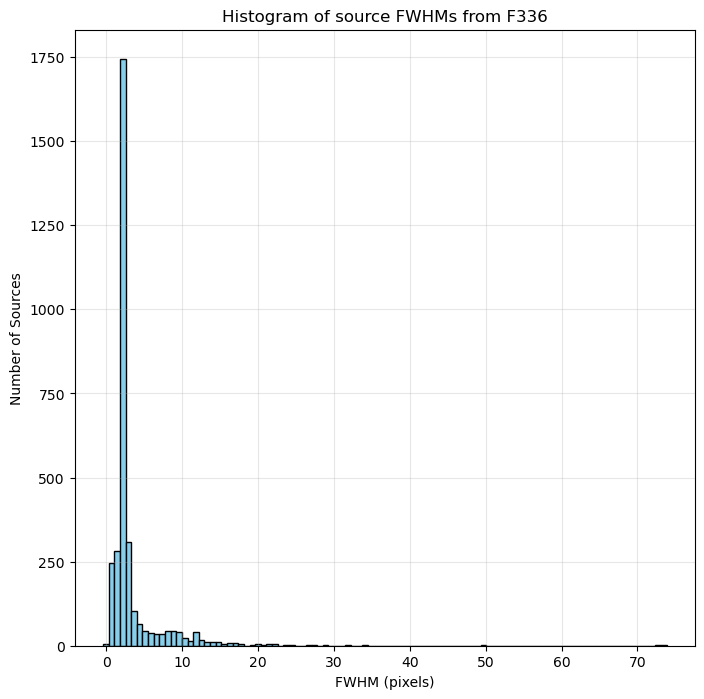

In [198]:
plt.close("all")
fig, ax = plt.subplots(figsize = (8, 8))
ax.set_title('Histogram of source FWHMs from F336')
ax.set_xlabel('FWHM (pixels)')
ax.set_ylabel('Number of Sources')

ax.hist(fwhm_336, bins=100, color='skyblue', edgecolor='black')

plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
fig, ax = plt.subplots

In [66]:
passed_336, failed_336, fwhm_336 = star_finder(combined_336)

C:\Users\Bruce Ritter\AppData\Local\Temp\ipykernel_15044\1522888017.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gauss_2d, (y, x), data.ravel(), p0 = p0)


In [78]:
#fwhm_336

In [15]:
len(passed_336)

3218

In [16]:
#checking if any of the fluxes are actually engative cuz ive been having probems:

In [18]:
def catalog_creator(data, coords):
    """
    This function will create a catalog of found stars including their coordinates, flux, and aparent magnitude

    Inputs: flux data array, array of passed (likely stars) coordinates
    Output: pandas dataframe:
        ID: ID of star
        x_center, y_center: center coordinates of star 
        flux: next flux within aperture, with background flux subtracted
        m_aparent : apparent magnitude
        m_absolute : absolute magnitude
    """

     #creating a catalog: 

    fluxes = []
    for coord in coords:
        fluxes.append(find_flux(data, coord))
    
    aparent_mags = []
    for flux in fluxes:
        aparent_mags.append(flux_to_apparent_mag(flux, -21.1)) #zp set to -21.1 for this data

    absolute_mags = []
    for mag in aparent_mags:
        absolute_mags.append(m_to_M(mag, 16400)) #distance = 16400 according to the hst workbook 3
    
    catalog_data = {
        'ID' : [i for i in range(len(coords))],
        'x_center':  [coord[0] for coord in coords],
        'y_center':  [coord[1] for coord in coords],
        'flux': fluxes,
        'm_aparent': aparent_mags,
        'm_absolute': absolute_mags,
    }

    return pd.DataFrame(catalog_data)

In [19]:
catalog_creator(combined_336, passed_336)

ID  x_center  y_center          flux  m_aparent  m_absolute
0        0         5       543  3.548718e-18  22.524821    6.450602
1        1         5       597  1.463235e-17  20.986715    4.912496
2        2         6        17  4.176377e-16  17.348001    1.273782
3        3         6       474  7.734635e-18  21.678900    5.604681
4        4         6       702  9.546989e-17  18.950334    2.876115
...    ...       ...       ...           ...        ...         ...
3213  3213       799       638  1.370433e-17  21.057856    4.983636
3214  3214       799       688  4.534335e-17  19.758716    3.684497
3215  3215       799       726  7.670030e-17  19.188007    3.113788
3216  3216       799       734  1.129387e-17  21.267893    5.193674
3217  3217       799       799  6.966417e-17  19.292476    3.218257

[3218 rows x 6 columns]

In [68]:
passed_555, failed_555, fwhm_555 = star_finder(combined_555)

C:\Users\Bruce Ritter\AppData\Local\Temp\ipykernel_15044\1522888017.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gauss_2d, (y, x), data.ravel(), p0 = p0)


In [69]:
#fwhm_555

In [21]:
catalog_creator(combined_555, passed_555)

ID  x_center  y_center          flux  m_aparent  m_absolute
0        0         5       118  3.548189e-18  22.524983    6.450764
1        1         5       262  3.443463e-18  22.557511    6.483292
2        2         6       585  2.561688e-17  20.378684    4.304465
3        3         7        41  8.149449e-18  21.622179    5.547960
4        4         7       378  5.454799e-18  22.058053    5.983834
...    ...       ...       ...           ...        ...         ...
3170  3170       799       114  1.789809e-17  20.767983    4.693764
3171  3171       799       124  2.146889e-17  20.570476    4.496257
3172  3172       799       390  6.240517e-17  19.411949    3.337729
3173  3173       799       583  7.209134e-17  19.255292    3.181073
3174  3174       799       726  6.557915e-17  19.358086    3.283866

[3175 rows x 6 columns]

In [22]:
#how many stars here are of the same coordinates I wonder? 

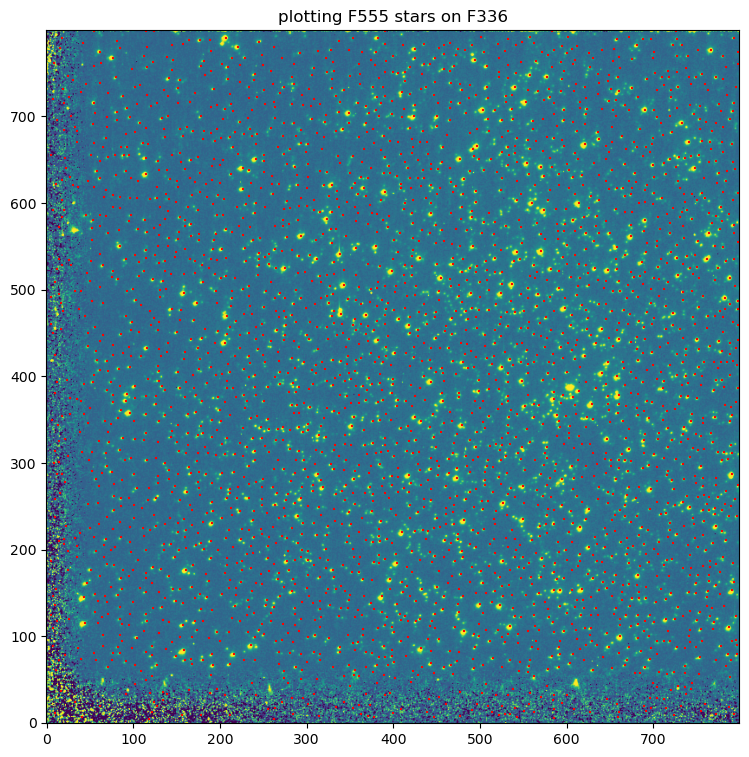

In [24]:
#testing: plot one images foud star coordinates on the other: 

plt.close("all")
fig, ax= plt.subplots(figsize = (9, 9))
ax.set_title("plotting F555 stars on F336")
smoothed_336 = ndi.gaussian_filter(combined_336, sigma = 0.5, mode = 'reflect')
smooth_norm = cutils.transform_by('sqrt', smoothed_336, pmin = 1, pmax = 99)
ax.imshow(smooth_norm, origin = 'lower')

y, x = passed_555.T
ax.scatter(x, y, s = 4, marker = '+', color = 'r')
plt.show()

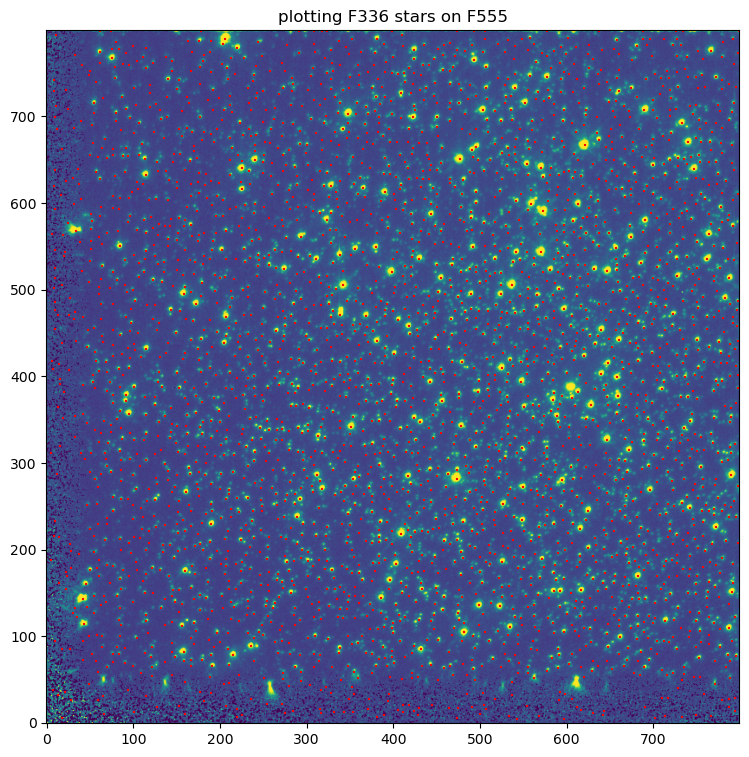

In [25]:
#testing: plot one images foud star coordinates on the other: 

plt.close("all")
fig, ax= plt.subplots(figsize = (9, 9))
ax.set_title("plotting F336 stars on F555")
smoothed_555 = ndi.gaussian_filter(combined_555, sigma = 0.5, mode = 'reflect')
smooth_norm = cutils.transform_by('sqrt', smoothed_555, pmin = 1, pmax = 99)
ax.imshow(smooth_norm, origin = 'lower')

y, x = passed_336.T
ax.scatter(x, y, s = 4, marker = '+', color = 'r')
plt.show()

In [26]:
#for now, I will use the 336 foun dstars on 555 i think

In [27]:
catalog_336_with_555_coords = catalog_creator(combined_336, passed_555)

C:\Users\Bruce Ritter\AppData\Local\Temp\ipykernel_15044\1996096152.py:3: RuntimeWarning: invalid value encountered in log10
  mag_data = -2.5 * np.log10(f) + zp


In [28]:
catalog_336_with_555_coords

ID  x_center  y_center          flux  m_aparent  m_absolute
0        0         5       118 -1.164397e-18        NaN         NaN
1        1         5       262 -2.716149e-18        NaN         NaN
2        2         6       585  1.658378e-17  20.850791    4.776572
3        3         7        41 -1.865609e-17        NaN         NaN
4        4         7       378 -9.925349e-18        NaN         NaN
...    ...       ...       ...           ...        ...         ...
3170  3170       799       114 -4.108135e-18        NaN         NaN
3171  3171       799       124  1.628750e-17  20.870364    4.796145
3172  3172       799       390  3.052146e-17  20.188487    4.114268
3173  3173       799       583  4.472626e-17  19.773594    3.699374
3174  3174       799       726  7.670030e-17  19.188007    3.113788

[3175 rows x 6 columns]

In [29]:
i = 0
for flux in catalog_336_with_555_coords["flux"]:
    if flux < 0:
        i+= 1

print(i)

81


In [30]:
#maybe I could pick stars that are close by to eachother: 

combined_catalog = {
    'ID' : [],
    'F336_x_center': [],
    'F555_x_center': [],
    'F336_y_center': [],
    'F555_y_center': [],
    'F336_flux': [],
    'F336_m_aparent': [],
    'F336_m_absolute': [],
    'F555_flux': [],
    'F555_m_aparent': [],
    'F555_m_absolute': [],
}

In [31]:
catalog_555 = catalog_creator(combined_555, passed_555)
catalog_336 = catalog_creator(combined_336, passed_336)

In [86]:
for i in catalog_555['ID']:
    for j in catalog_336['ID']:
        if (np.abs(catalog_555['x_center'][i] - catalog_336['x_center'][j]) <=2) & (np.abs(catalog_555['y_center'][i] - catalog_336['y_center'][j]) <=2): 
            #these are probably the same stars
            combined_catalog['F336_x_center'].append(catalog_336['x_center'][j])
            combined_catalog['F336_y_center'].append(catalog_336['y_center'][j])
            combined_catalog['F555_x_center'].append(catalog_555['x_center'][i])
            combined_catalog['F555_y_center'].append(catalog_555['y_center'][i])

        

In [92]:
len(combined_catalog['F336_x_center'])

2541

In [32]:
len(catalog_336)

3218

In [33]:
len(catalog_555)

3175

In [34]:
catalog_555_with_336_coords = catalog_creator(combined_555, passed_336)

C:\Users\Bruce Ritter\AppData\Local\Temp\ipykernel_15044\1996096152.py:3: RuntimeWarning: invalid value encountered in log10
  mag_data = -2.5 * np.log10(f) + zp


In [35]:
catalog_555_with_336_coords

ID  x_center  y_center          flux  m_aparent  m_absolute
0        0         5       543  7.032652e-18  21.782202    5.707983
1        1         5       597  5.399767e-18  22.069062    5.994843
2        2         6        17 -3.813720e-17        NaN         NaN
3        3         6       474  3.193016e-19  25.139497    9.065278
4        4         6       702  8.509760e-18  21.575207    5.500987
...    ...       ...       ...           ...        ...         ...
3213  3213       799       638  5.370902e-17  19.574882    3.500663
3214  3214       799       688  6.400055e-17  19.384541    3.310321
3215  3215       799       726  6.557915e-17  19.358086    3.283866
3216  3216       799       734  4.805012e-17  19.695764    3.621545
3217  3217       799       799  6.003139e-17  19.454054    3.379835

[3218 rows x 6 columns]

In [36]:
i = 0
for flux in catalog_555_with_336_coords['flux']:
    if flux < 0:
        i+= 1

print(i)

88


In [37]:
#so 88 spots where a source is no where near the same place in both catalogs? 

In [38]:
indices = catalog_555_with_336_coords.index[catalog_555_with_336_coords['flux'] < 0].tolist()

In [39]:
indices[0:5]

[2, 5, 6, 10, 13]

In [40]:
adjusted_555_catalog = catalog_555_with_336_coords.copy()

In [41]:
for i in adjusted_555_catalog['ID']:
    if i in indices:
        adjusted_555_catalog = adjusted_555_catalog.drop(index = i)

In [42]:
adjusted_555_catalog

ID  x_center  y_center          flux  m_aparent  m_absolute
0        0         5       543  7.032652e-18  21.782202    5.707983
1        1         5       597  5.399767e-18  22.069062    5.994843
3        3         6       474  3.193016e-19  25.139497    9.065278
4        4         6       702  8.509760e-18  21.575207    5.500987
7        7         7       733  7.365500e-18  21.731994    5.657775
...    ...       ...       ...           ...        ...         ...
3213  3213       799       638  5.370902e-17  19.574882    3.500663
3214  3214       799       688  6.400055e-17  19.384541    3.310321
3215  3215       799       726  6.557915e-17  19.358086    3.283866
3216  3216       799       734  4.805012e-17  19.695764    3.621545
3217  3217       799       799  6.003139e-17  19.454054    3.379835

[3130 rows x 6 columns]

In [43]:
def compare_catalogs(cat_1, cat_2):
    """
    This function will compare stars found in catalogs and return two catalogs with the same star coordinates.
    The star finding functions find peaks that are close to each other most of the time (from what I can tell),
    so this function will find flux and magnitudes with coordinates from the first catalog and data from the seconds, 
    then remove coordinates where the flux ends up negative. 

    Inputs: two catalogs (pandas dataframes)
    Outputs: two adjusted catalogs (pandas dataframes)
    """

    adjusted_cat_1 = cat_1.copy()
    adjusted_cat_2 = cat_2.copy()

    indices = cat_2.index[cat_2['flux'] < 0].tolist()

    for i in adjusted_cat_2['ID']:
        if i in indices:
            adjusted_cat_2 = adjusted_cat_2.drop(index = i)

    for i in adjusted_cat_1['ID']:
        if i in indices:
            adjusted_cat_1 = adjusted_cat_1.drop(index = i)

    return adjusted_cat_1, adjusted_cat_2

In [44]:
adjusted_336, adjusted_555 = compare_catalogs(catalog_336, catalog_555_with_336_coords)

In [45]:
adjusted_336

ID  x_center  y_center          flux  m_aparent  m_absolute
0        0         5       543  3.548718e-18  22.524821    6.450602
1        1         5       597  1.463235e-17  20.986715    4.912496
3        3         6       474  7.734635e-18  21.678900    5.604681
4        4         6       702  9.546989e-17  18.950334    2.876115
7        7         7       733  3.206228e-17  20.135014    4.060795
...    ...       ...       ...           ...        ...         ...
3213  3213       799       638  1.370433e-17  21.057856    4.983636
3214  3214       799       688  4.534335e-17  19.758716    3.684497
3215  3215       799       726  7.670030e-17  19.188007    3.113788
3216  3216       799       734  1.129387e-17  21.267893    5.193674
3217  3217       799       799  6.966417e-17  19.292476    3.218257

[3130 rows x 6 columns]

In [46]:
adjusted_555

ID  x_center  y_center          flux  m_aparent  m_absolute
0        0         5       543  7.032652e-18  21.782202    5.707983
1        1         5       597  5.399767e-18  22.069062    5.994843
3        3         6       474  3.193016e-19  25.139497    9.065278
4        4         6       702  8.509760e-18  21.575207    5.500987
7        7         7       733  7.365500e-18  21.731994    5.657775
...    ...       ...       ...           ...        ...         ...
3213  3213       799       638  5.370902e-17  19.574882    3.500663
3214  3214       799       688  6.400055e-17  19.384541    3.310321
3215  3215       799       726  6.557915e-17  19.358086    3.283866
3216  3216       799       734  4.805012e-17  19.695764    3.621545
3217  3217       799       799  6.003139e-17  19.454054    3.379835

[3130 rows x 6 columns]

In [47]:
#yippee they are the same, time to make an HR diagram and see if I messed this up or not:

In [107]:
#HR diagram: M(336 -555) by M336 (color color plot)

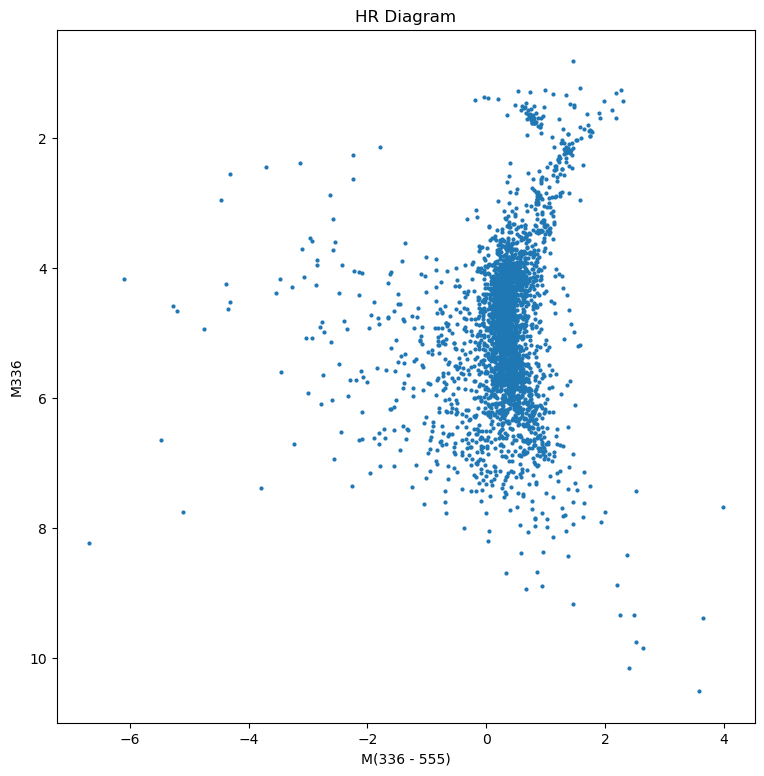

In [94]:
plt.close("all")
fig, ax = plt.subplots(figsize = (9,9))
ax.set_title("HR Diagram")
ax.set_ylabel("M336")
ax.set_xlabel("M(336 - 555)")

ax.scatter((adjusted_336["m_absolute"] - adjusted_555["m_absolute"]), adjusted_336["m_absolute"], s = 4)
plt.gca().invert_yaxis()
plt.show()

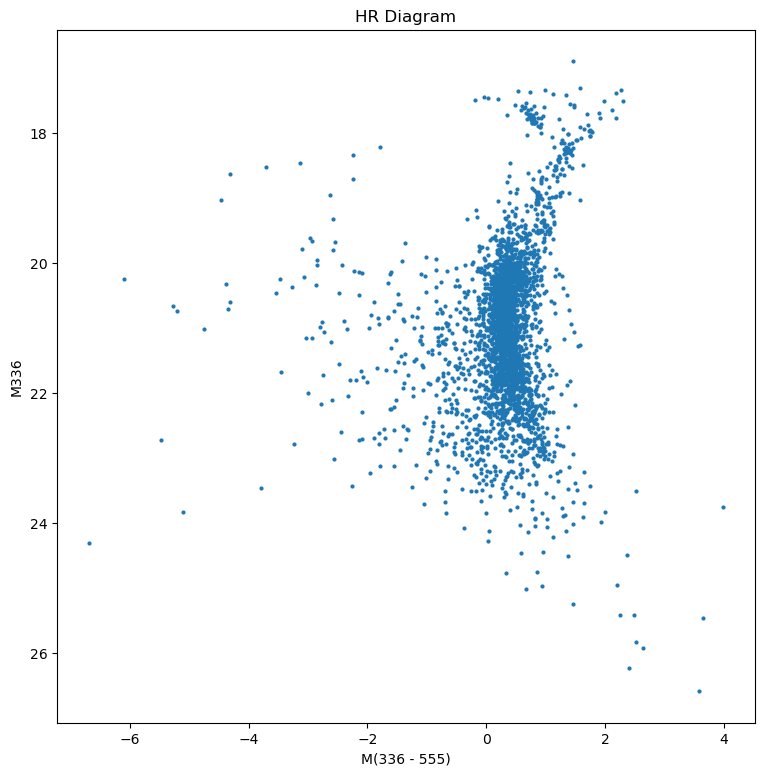

In [96]:
plt.close("all")
fig, ax = plt.subplots(figsize = (9,9))
ax.set_title("HR Diagram")
ax.set_ylabel("M336")
ax.set_xlabel("M(336 - 555)")

ax.scatter((adjusted_336["m_aparent"] - adjusted_555["m_aparent"]), adjusted_336["m_aparent"], s = 4)
plt.gca().invert_yaxis()
plt.show()

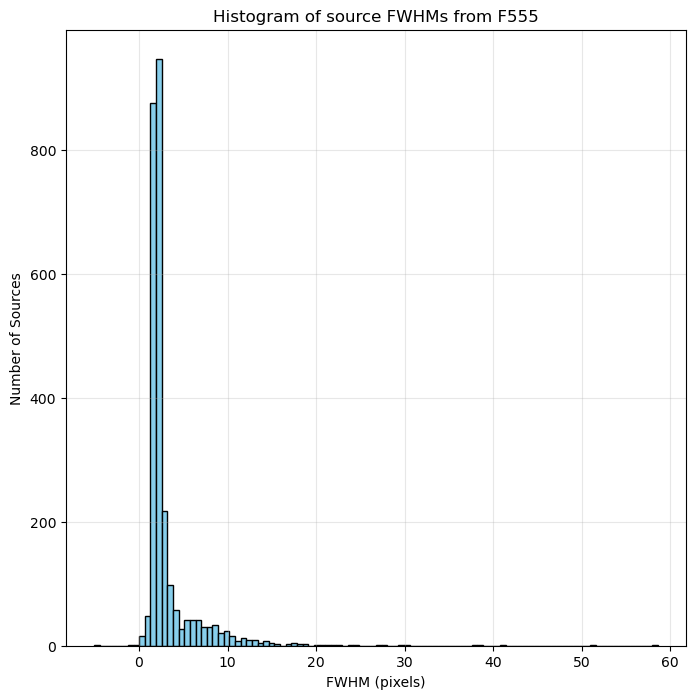

In [195]:
#creating histogram of fwhm's :

plt.close("all")
fig, ax = plt.subplots(figsize = (8, 8))
ax.set_title('Histogram of source FWHMs from F555')
ax.set_xlabel('FWHM (pixels)')
ax.set_ylabel('Number of Sources')

ax.hist(fwhm_555, bins=100, color='skyblue', edgecolor='black')

plt.grid(True, alpha=0.3)
plt.show()

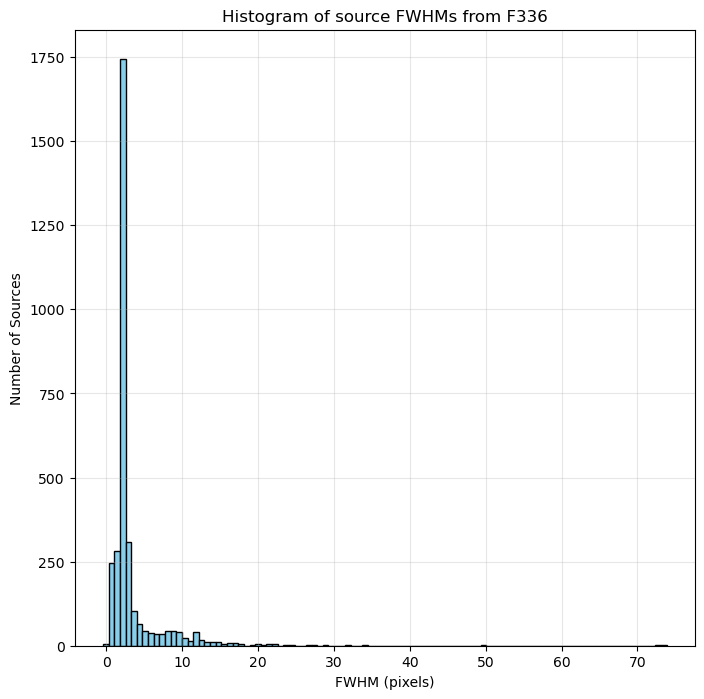

In [196]:
plt.close("all")
fig, ax = plt.subplots(figsize = (8, 8))
ax.set_title('Histogram of source FWHMs from F336')
ax.set_xlabel('FWHM (pixels)')
ax.set_ylabel('Number of Sources')

ax.hist(fwhm_336, bins=100, color='skyblue', edgecolor='black')

plt.grid(True, alpha=0.3)
plt.show()